# Training Neural SDEs with the signature kernel scoring rule: The conditional case

In this notebook, we show how one can use the signature kernel and the signature kernel scoring rule to train a generative model to learn conditional distributions on path space. 

#### Introduction.
Suppose one observes path segments $x: [0, s] \to \mathbb{R}^d$ for some $0 < s< T$, and the associated resultant paths conditional on $x$ are given by $y: [s, T] \to \mathbb{R}^d$. One can build a bank of input-output pairs $\{(x^i, y^i)\}_{i=1}^N$ where $N$ is the dataset size. The problem is to train a generator to learn the conditional distributon $\mathbb{P}_{X^{\text{true}}}(\cdot |x)$, where $x$ is a given path segment up until $s \in [0, T]$. 

We will use a neural SDE as a generator. However, the architecture will need to be modified to admit path segments as conditions. In general, the generator will need to take the form 

\begin{equation}
    G: \Theta \times \mathcal{Z} \times C([0, s]; \mathbb{R}^d) \to C([s, T]; \mathbb{R}^d),
\end{equation}

where $(\mathcal{Z}, \mathbb{P}_\mathcal{Z})$ is the associated latent space (here, taken to be Wiener space $(W, \mathbb{W})$, as we do not enforce an initial condition distributon on paths sampled from $G$). 

#### Generator architectures. 

We propose the following architecture to conditionalize path data. For each conditioning path $x$, extract the order $N$ signature $S^N(x)$ and feed these to the generator. In theory the (untruncated) signature mapping is sufficient to deliniate between conditioning paths. However in practice one is not able to calculate this infinite-dimensional object. Thus there is a trade-off. 

The signature method can become prohibitive from a memory standpoint (especially as the dimensionality of the paths expands), however it does not increase the size of the parameter set and thus can be more efficent from a runtime perspective. Formally, the functions in the generator in a forward pass are all augmented with the values

\begin{equation*}
    S^N(x) = (1, \mathbb{X}^1(x), \mathbb{X}^2(x), \dots, \mathbb{X}^N(x)),
\end{equation*}

where

\begin{equation*}
    \mathbb{X}^k(x) = \bigoplus_{i_1, \dots, i_k \in \{1, \dots, d\}^k} \int \dots \int_{0\le t_1 \le t_k\le T} dx^{i_1}_{t_1}\dots dx^{i^k}_{t_k}
\end{equation*}

is the signature of level $k$ of the path $x$. In this way the neural networks defining the vector fields in the generator (for instance) are now mappings defined as 

\begin{gather*}
    \mu_\theta: [s, T] \times \mathbb{R}^y \times \mathbb{R}^{1 + d + d^2 + \dots + d^N} \to \mathbb{R}^y, \\
    \sigma_\theta: [s, T] \times \mathbb{R}^y \times \mathbb{R}^{1 + d + d^2 + \dots + d^N} \to \mathbb{R}^{y \times w}. \\
\end{gather*}

Dimensionality issues can be avoided by using the log-signature. In the notebook, we provide options for different path transformations on the space of input and output paths, along with the order and type of signature taken on the conditioning paths.

#### Discriminator and loss function.

As we only observe one "true" path $y: [s, T] \to \mathbb{R}^d$ for each conditioning path $x$, one cannot traditional metrics on the space of measures on path space (K-L, MMD, Wasserstein). Attempts to generate counterfactuals from the observed paths rely on certain assumptions about the data which need not hold in practice, or in fact be directly refutably (stationary and non-Markovianity are two obvious ones). One could use a conditional version of the MMD$^1$ however this machinery relies on conditional mean embeddings$^2$</b> and thus a different approach is required. 

We propose training conditional NSDEs using the signature kernel scoring rule $\phi_{\text{sig}}$. In this setting, the training loss becomes

\begin{equation*}
    \min_\theta \mathcal{L}'(\theta) \quad \text{where} \quad \mathcal{L}'(\theta)  = \min_\theta \mathbb{E}_{x \sim \mathbb{Q}}\mathbb{E}_{y \sim \mathbb{P}_{X^{\text{true}}}(\cdot|x)}\left[\phi_{\text{sig}}(\mathbb{P}_{X^\theta}(\cdot|x), y)\right].
\end{equation*}

The loss over a batch $B = \{(x^i, y^i)\}_{i=1}^{n}$ is thus given by

\begin{equation*}
    \min_\theta \frac{1}{n}\sum_{i=1}^n \phi_{\text{sig}}(\mathbb{P}_{X^\theta}(\cdot|x^i), y^i).
\end{equation*}

#### Final notes. 

This method is theoretically guaranteed, but can be quite tricky to train. Out Of Memory (OOM) errors often occur, primarily due to the <code>.backward()</code> of the loss function. The computational graph can explode quite quickly, especially in the signature method.

The hyperparameters provided are able to be run with 8GB of GPU memory. 

_______________

$^1$ See https://arxiv.org/pdf/1606.04218.pdf.

$^2$ Terribly unstable computationally, due to matrix inversions.


In [15]:
RUN_PRE_CHECKS = False

import math
from collections import OrderedDict

import torch
import torch.optim.swa_utils as swa_utils
import numpy as np
import matplotlib.pyplot as plt
import signatory

from IPython import display
from tqdm import tqdm

from src.gan.base import (
    preprocess_real_data,
    get_real_data,
    get_scheduler,
    calculate_batch_conditional_scoring_loss,
    evaluate_conditional_scoring_loss
)
from src.gan.generators import PathConditionalSigGenerator
from src.gan.discriminators import SigKerScoreDiscriminator
from src.gan.output_functions import plot_loss
from src.utils.helper_functions.global_helper_functions import get_project_root, mkdir
from src.utils.helper_functions.data_helper_functions import subtract_initial_point, \
    get_scalings, process_generator, batch_subtract_initial_point, normalize, inv_normalize
from src.utils.helper_functions.plot_helper_functions import make_grid, plot_line_error_bars

from src.utils.transformations import Transformer

# plt.style.use('science')
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']  = 22
# plt.rcParams['text.usetex']         = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amsfonts}'

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [16]:
torch.manual_seed(0)

### Layout. 

This notebook is broken into four sections: 

1) <b>Data:</b> The conditional measure to be learnt on pathspace. We present three examples:
    1) $gbm_{1, 2, 3} \to gbm_{1, 2, 3}$: Conditioning paths come from three separate measures. Output path has the same distribution as the conditioning path.
    2) $gbm \to gbm_{1, 2, 3}$ Conditioning paths come from the same measure. Output paths are built from a non-Markovian condition on the conditioning paths. Output paths have a different distribution to the conditioning path.
    3) Forex data. Paths are extracted from real data, split uniformly at a chosen point.

2) <b>Generator:</b> This will always be a neural SDE, augmented to accept path data as a conditioning variable, as per the Introduction to this notebook.

3) <b>Discriminator:</b> We use batched scoring rules, as explained in the Introduction.

4) <b>Training the GAN and evaluation:</b> The GAN is then trained. We evaluate the performance visually, and in the synthetic case we are directly able to verify whether the training has been successful or not.

There is also a sub-section that can be run before training to check if the GAN is likely to successfully converge. You can force this to run by setting <code>RUN_CHECKS</code> to <code>True</code> in the Imports section.

In [17]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'

if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

# You realistially need GPU access (either natively or via cloud computing) to run this notebook.

## 0. Configuration

This is the universal configuration which sets the data loading, generator and discriminator hyperparameters, training types, and so on. Each value is annotated.

In [ ]:
# Data arguments
## Data hyperparameters
output_dim          = 1                     # Dimension of the outputs.
batch_size          = 60                   # Size of minibatches when training.
path_length         = 48                    # Number of timesteps in paths.
dataset_size        = batch_size*3        # Number of paths in the train/test datasets.
normalisation       = None                  # How to transform paths. Options are None, "mean_var", "min_max"
scale               = 1e3                   # Float scale to each path dimension.
time_add_type       = "basic"               # Controls how time is accounted for. "basic" -> 0, 1, 2..., "realistic" -> real times.

## Data generation / dataset arguments
data_type             = "forex"                      # "syn_type1", "syn_type2", "forex"
change_pt             = 32         # When to split paths into conditional/resolvant pairs
cond_length           = 32                    # Length of conditioning paths
eval_length           = int(path_length - change_pt) # Length of conditioned paths
tt_split              = 1.0                          # Train/test split

filter_extremal_paths = False                # Filter out extremal values (by tv and terminal value)
filter_extremal_pct   = 0.95                 # Quantile to filter out, if the above is TRUE

forex_pairs           = ["SPX"]           # "EURUSD", "USDJPY", "BTCUSD", "BRENTCMDUSD"
stride_length         = 50                    # Number of timesteps to stride when creating path data.
frequency             = "H1"                # Choice of "H1", "M15", "M30"

# drift_values          = [0.1, 0. , -0.1]     # mu0, mu1, mu2 for synthetic example
# diffusion_values      = [0.2, 0.2, 0.2]      # sig0, sig1, sig2 for synthetic example
# process_type          = "bm"                 # "gbm" or "bm"
# syn2_mask_type        = "qv"                 # "tv" or "qv" (total or quadratic variation)
# dt                    = 1e0                  # Timestep size for simulation. Note T = path_length*dt.
# S0                    = 0.                   # Starting value

# Path transformation types/arguments
do_transforms            = True  # Whether to apply path transformations

cond_transformations     = OrderedDict([
    ("scale"             , False),
    ("visibility"        , False),
    ("time_difference"   , False),
    ("time_normalisation", True),
    ("lead_lag"          , True),
    ("basepoint"         , False)
])

cond_transformation_args = OrderedDict([
    ("scale"             , {"scaler": 1e-1}),
    ("visibility"        , {}),
    ("time_difference"   , {}),
    ("time_normalisation", {}),
    ("lead_lag"          , {"time_in": True, "time_out": False, "time_normalisation": False}),
    ("basepoint"         , {})
])

out_transformations     = OrderedDict([
    ("scale"             , False),
    ("visibility"        , False),
    ("time_difference"   , False),
    ("time_normalisation", True),
    ("lead_lag"          , False),
    ("basepoint"         , False)
])

out_transformation_args = OrderedDict([
    ("scale"             , {"scaler": 1e-1}),
    ("visibility"        , {}),
    ("time_difference"   , {}),
    ("time_normalisation", {}),
    ("lead_lag"          , {"time_in": True, "time_out": False, "time_normalisation": False}),
    ("basepoint"         , {})
])

subtract_start = True  # You almost always want this to be TRUE

# Generator arguments
## Unconditional_arguments
generator_config = {
    "noise_size"         : 8,                 # How many dimensions the Brownian motion has.
    "hidden_size"        : 16,                # Size of the hidden state of the generator SDE.
    "mlp_size"           : 64,                # Size of the layers in the various MLPs.
    "num_layers"         : 3,                 # Numer of hidden layers in the various MLPs.
    "activation"         : "LipSwish",        # Activation function to use over hidden layers
    "tanh"               : True,              # Whether to apply final tanh activation
    "tscale"             : 1,                 # Clip parameter for tanh, i.e. [-1, 1] to [-c, c]
    "fixed"              : True,              # Whether to fix the starting point or not
    "noise_type"         : "general",         # Noise type argument for torchsde
    "sde_type"           : "ito",             # SDE integration type from torchsde
    "dt_scale"           : 1e0,               # Grid shrinking parameter. Lower values are computationally more expensive
    "integration_method" : "euler"            # Integration method for torchsde
}

## Conditional arguments

emp_size         = 32                # Size of empirical measure made by generator

conditional_config = {
    "logsig"          : True,        # Use logsignature in conditional generator
    "order"           : 5,           # Order of signature to take
    "sig_scale"       : 1e0,         # Constant x which scales sig level k by x^k
}


# Discriminator arguments
adversarial           = False         # Whether to adversarially train the discriminator or not.
clip_disc_param       = True          # MMD-based discriminators only: whether to ensure the scaling param stays above 1


discriminator_args = {
    "dyadic_order"       : 1,         # Mesh size of PDE solver used in loss function
    "kernel_type"        : "rbf",     # Type of kernel to use in the discriminator
    "sigma"              : 1.0,       # Sigma in RBF kernel
    "use_phi_kernel"     : False,     # Whether to use the the phi(k) = (k/2)! scaling.
    "n_scalings"         : 10,        # Number of samples to draw from Exp(1)
    "max_batch"          : 32         # Maximum batch size to pass through the discriminator.
}


# Training hyperparameters
## Optimiser parameters
generator_lr     = 2e-06         # Generator initial learning rate
discriminator_lr = None         # Discriminator initial learning rate
steps            = 10000         # How many steps to train both generator and discriminator for.
init_mult1       = 1             # Changing the initial parameter size can help.
init_mult2_dr    = 2e0           # Changing vector field MLP initial parameter size.
init_mult2_df    = 1e0           # Changing vector field MLP initial parameter size.
init_mult3       = 1             # Initial parameter size for discriminator
weight_decay     = 0.01          # Weight decay.
swa_step_start   = int(steps/2)  # When to start using stochastic weight averaging.
gen_optim        = "Adam"        # Optimiser for generator
disc_optim       = "Adam"        # Optimiser for discriminator

## Learning rate annealear arguments
adapting_lr            = False           # Whether to make the learning rate adaptive.
adapting_lr_type       = "StepLR"        # LR scheduler type
lambda_lr_const        = 0.5             # If LambdaLR, learning rate fraction to reduce to
poly_exponent_smoother = -0.5            # If LambdaLR, poly exponent to decrease to
mult_const             = 1.01            # If MultiplicativeLR, val of a for \eta_{t+1} = a\eta_t
gamma_lr               = 0.5             # If StepLR, multiplier for learning rate
steps_lr               = int(2*steps/3)  # If StepLR, when to change learning rate
max_lr                 = 1e-06           # OneCycleLR: Maximum rate
anneal_strategy        = "cos"           # OneCycleLR: Anneal type
total_steps            = steps           # OneCycleLR: Anneal rate
pct_start              = 0.3             # OneCycleLR: Percentage of schedule increasing rate
div_factor             = 10              # OneCycleLR: Final lr as a percentage of max

## Early stopping
early_stopping_type = None         # Early stopping type ('marginals', 'mmd', or None)
crit_evals          = 20           # Marginals: number of evaluations of criterion
crit_thresh         = 0.975        # Marginals: stopping threshold
cutoff              = 0.975        # Marginals: cutoff of marginal distributions to remove extremal values
mmd_ci              = 0.95         # mmd: Confidence on null distribution
mmd_atoms           = steps_lr     # mmd: number of atoms to build null distribution
mmd_periods         = 50           # mmd: number of lagged periods to compare threshold to

## Evaluation and plotting hyperparameters
steps_per_print  = int(steps/10)              # How often to print the loss.
num_plot_samples = int(batch_size/2)          # How many samples to use on the plots at the end.
plot_locs        = (0.1, 0.3, 0.5, 0.7, 0.9)  # Plot some marginal distributions at this proportion of the way along.

## 1. Data

We now generate our training and testing data.

In [19]:
if data_type == "forex":
    ## Real data regime

    data_kwargs = {
        "dataset_size": dataset_size,
        "path_length": path_length,
        "batch_size": batch_size,
        "step_size": stride_length,
        "learning_type": "paths",
        "time_add_type": time_add_type,
        "train_test_split": tt_split
    }

    real_data_kwargs = {
        "pairs": forex_pairs,
        "frequency": frequency,
        "filter_extremal_paths": filter_extremal_paths,
        "filter_extremal_pct": filter_extremal_pct
    }

    np_train_data, np_test_data, no_null_data = preprocess_real_data(data_kwargs, real_data_kwargs)

elif "syn" in data_type:
    ## We are in the synthetic case
    extract_size = int(2*dataset_size)

    if time_add_type == "basic":
        times = np.linspace(0, path_length-1, path_length)
    else:
        times = np.linspace(0, path_length*dt, path_length)

    np_data         = np.zeros((extract_size, path_length, int(1 + output_dim)))
    np_data[..., 0] = np.tile(times, (extract_size, 1))

    mu0, mu1, mu2    = drift_values
    sig0, sig1, sig2 = diffusion_values

    ## Iterate over synthetic test types
    if data_type == "syn_type1":
        ## gbm_i -> gbm_i.

        inds  = np.permutation(np.arange(dataset_size))
        mask0 = inds[:int(extract_size/3)]
        mask1 = inds[int(extract_size/3):int(2*extract_size/3)]
        mask2 = inds[int(2*extract_size/3):]

        for i in range(2):
            this_mask         = eval(f"mask{i}")
            this_mu, this_sig = eval(f"mu{i}"), eval(f"sig{i}")

            np_data[this_mask, :, 1:] = np.expand_dims(process_generator(
                sum(this_mask), dt*(path_length-1), path_length, this_mu, this_sig, S0, proc=process_type
            ), axis=-1)

    else:
        ## gbm -> gbm_{1, 2, 3}

        np_data[:, :cond_length, 1:] = np.expand_dims(process_generator(
            extract_size, dt*(cond_length-1), cond_length, mu1, sig1, S0, proc=process_type
        ), axis=-1)

        S0_ = np_data[:, cond_length-1, 1]

        # Non-Markovian example
        mfunc = lambda x: np.power(x, 2) if syn2_mask_type == "qv" else np.abs(x)

        nm_condition = np.sum(mfunc(np.diff(np_data[:, :cond_length, 1], axis=1)), axis=1)
        quantiles    = np.quantile(nm_condition, [0.33, 0.66])

        mask0 = nm_condition <= quantiles[0]
        mask1 = (nm_condition <= quantiles[1])*(nm_condition > quantiles[0])
        mask2 = nm_condition > quantiles[1]

        for i in range(3):
            this_mask = eval(f"mask{i}")
            this_mu   = eval(f"mu{i}")
            this_sig  = eval(f"sig{i}")

            np_data[this_mask, cond_length-1:, 1:] = np.expand_dims(process_generator(
                sum(this_mask), dt*(eval_length), eval_length+1, this_mu, this_sig, S0_[this_mask], proc=process_type
            ), axis=-1)

    random_indexes = np.random.permutation(np.arange(np_data.shape[0]))
    train_indexes  = random_indexes[:dataset_size]
    test_indexes   = random_indexes[dataset_size:extract_size]

    # Scale everything up here.
    #np_data[..., 1] *= scale

    np_train_data = np_data[train_indexes].copy()
    np_test_data  = np_data[test_indexes].copy()

else:
    np_train_data, np_test_data = None, None
    print("Data extraction type is not available")

In [20]:
if data_type == "syn_type2":
    n_path_plots = 64
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    ax1, ax2 = axes
    make_grid(axis=ax1)
    case1 = np_data[mask0, -1, 1]
    case2 = np_data[mask1, -1, 1]
    case3 = np_data[mask2, -1, 1]

    ax1.hist(case1, bins=128, alpha=0.5, color= "dodgerblue" , density=True, label="mask_0")
    ax1.hist(case2, bins=128, alpha=0.5, color= "slategrey"  , density=True, label="mask_1")
    ax1.hist(case3, bins=128, alpha=0.5, color= "tomato"     , density=True, label="mask_2")

    ax1.legend();

    make_grid(axis=ax2)
    case1_paths    = np_data[mask0, :, 1][:n_path_plots]
    case2_paths    = np_data[mask1, :, 1][:n_path_plots]
    case3_paths    = np_data[mask2, :, 1][:n_path_plots]

    for i in range(n_path_plots):
        label1 = "mask_0" if i == 0 else ""
        label2 = "mask_1" if i == 0 else ""
        label3 = "mask_2" if i == 0 else ""
        ax2.plot(case1_paths[i], color="dodgerblue" , alpha=0.25, label=label1)
        ax2.plot(case2_paths[i], color="slategrey", alpha=0.25, label=label2)
        ax2.plot(case3_paths[i], color="tomato"    , alpha=0.25, label=label3)
    ax2.legend()

In [21]:
# Package into torch dataloader
(tpast, ts), data_size, train_dataloader, means, stds = get_real_data(
    np_train_data, batch_size, dataset_size, device, time_add_type, time_add_round=4, filter_by_time=True,
    split=change_pt, normalisation=normalisation, initial_point=False, scale=scale
)

# _, _, test_dataloader, _, _ = get_real_data(
#     np_test_data, batch_size, dataset_size, device, time_add_type, time_add_round=4, filter_by_time=True,
#     split=change_pt, normalisation=normalisation, initial_point=False, scale=scale
# )

infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

cond_transformer   = Transformer(cond_transformations, cond_transformation_args, device).to(device) if do_transforms else lambda x: x
out_transformer    = Transformer(out_transformations, out_transformation_args, device).to(device) if do_transforms else lambda x: x

UnboundLocalError: local variable 'means' referenced before assignment

## 2. Discriminator

Here, we initialize the discriminator object.

In [8]:
discriminator = SigKerScoreDiscriminator(
    path_dim     = output_dim,
    adversarial  = adversarial,
    **discriminator_args
).to(device)

if adversarial:
    for param in discriminator.parameters():
        param = param*init_mult3

## 3. Generator

As mentioned in the introduction, this initialises the conditional generator.

In [9]:
conditioning_dim = data_size

if cond_transformations["lead_lag"]:
    if cond_transformation_args["lead_lag"]["time_out"]:
        conditioning_dim += 1

extra_config = {k: conditional_config[k] for k in ("logsig", "order", "sig_scale")}
total_config = {**generator_config, **extra_config, **{"conditioning_dim" : conditioning_dim}}

generator    = PathConditionalSigGenerator(data_size=data_size, **total_config).to(device)

with torch.no_grad():
    for name, prm in generator._func.named_parameters():
        if "_drift" in name:
            prm.data*=init_mult2_dr
        else:
            prm.data*=init_mult2_df

## 4. Optimisers and Annealers

In [10]:
averaged_generator     = swa_utils.AveragedModel(generator)
averaged_discriminator = swa_utils.AveragedModel(discriminator)

generator_optimiser_    = getattr(torch.optim, gen_optim)
generator_optimiser     = generator_optimiser_(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
generator_optimiser.zero_grad()

if adversarial:
    discriminator_optimiser = getattr(torch.optim, disc_optim)(discriminator.parameters(), lr=discriminator_lr, weight_decay=weight_decay)
    discriminator_optimiser.zero_grad()
else:
    discriminator_optimiser = None

if adapting_lr:
    if adapting_lr_type == "LambdaLR":
        f_lmd = lambda epoch: (1-lambda_lr_const)*np.power(epoch + 1., poly_exponent_smoother) + lambda_lr_const
        adpt_kwargs = {"lr_lambda": f_lmd}
    elif adapting_lr_type == "StepLR":
        adpt_kwargs = {"gamma": gamma_lr, "step_size":steps_lr}
    elif adapting_lr_type == "MultiplicativeLR":
        adpt_kwargs = {"lr_lambda": lambda epoch: mult_const}

    elif adapting_lr_type == "OneCycleLR":
        adpt_kwargs = {
            "max_lr": max_lr,
            "total_steps": total_steps,
            "pct_start": pct_start,
            "anneal_strategy": anneal_strategy,
            "div_factor": div_factor
        }

    g_scheduler, d_scheduler = get_scheduler(
        generator_optimiser,
        discriminator_optimiser,
        adapting_lr_type,
        adversarial,
        **adpt_kwargs
    )

## 5. Pre-checks 

These are optional. You can turn specific ones off/on with the variables below. We provide an explanation of each pre-check alongside it. 

Note that if the <code>RUN_PRE_CHECKS</code> global variable is set to False, none of the checks will run.

### 5.1 Initial distribution of (conditional) generated paths.

To help facilitate learning, one would like the variance of the initially generated paths to match the real-data paths. The following gives a visual indiciation as to whether this is the case or not. One can adjust the degree of variance with the <code>init_mult2_df</code> parameter in the optimiser section of the configuration. 

In [11]:
# Check the initial distribution to calibrate size of initial vector fields (makes training easier!)
if RUN_PRE_CHECKS:

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    n_plot_samples = 32

    cond_samples, true_samples = next(infinite_train_dataloader)

    with torch.no_grad():
        cond_samples      = cond_transformer(subtract_initial_point(cond_samples))
        generated_samples = batch_subtract_initial_point(generator(ts, cond_samples, emp_size))
        true_samples      = subtract_initial_point(true_samples)

        generated_plot_samples = generated_samples[:n_plot_samples, 0, :, 1].cpu()
        true_plot_samples      = true_samples[:n_plot_samples, :, 1].cpu()

        generated_first = True
        real_first      = True

        for xi, yi in zip(generated_plot_samples, true_plot_samples):
            g_kwargs = {"label": "generated"} if real_first else {}
            r_kwargs = {"label": "real"} if generated_first else {}

            plt.plot(xi, color="tomato", alpha=0.25, **g_kwargs)
            plt.plot(yi, color="dodgerblue", alpha=0.25, **r_kwargs)

            generated_first = False
            real_first      = False

        plt.legend()
        plt.title("Initialisation of $G$ against real data")
        make_grid()

### 5.2 Moment ratio values. 

Suppose $y: [t, T] \to \mathbb{R}^d$ is an observed path conditional on $x \in \mathcal{C}([0, t]; \mathbb{R}^d)$, so $y \sim \mathbb{P}_{X^{\text{true}}}(\cdot|x)$. 

For learning with the signature kernel, it helps to check the distribution of the moments of the random variable $\Delta y = y_T - y_0$. As the signature kernel between two paths is given by

\begin{equation*}
    k_{\mathrm{sig}}(x, y) = \sum_{k\ge 0} \sum_{i_1, \dots, i_k \in \{1, 2, \dots, d\}^k} S(x)^{i_1, \dots, i_k} \cdot S(y)^{i_1, \dots, i_k},
\end{equation*}

and, for $i_1, \dots, i_k \in \{1, \dots, d\}^k$ where $i_1 = i_2 = \dots = i_k$,

\begin{equation*}
    S(y)^{i_1, \dots, i_k} = \int_{t \le t_k \le T} \dots \int_{t \le t_1 \le t_2} dy^{i_1}_{t_1} \dots dy^{i_k}_{t_k} = \frac{(\Delta y^{i_k})^k}{k!},
\end{equation*}

so we approximate the magnitude of each level via the increment of $y$ along a given spatial dimension. These values are of interest as (we theorize) the direction of steepest descent when backpropagating through the batched scoring rule will be given by that which reduces the impact coming from the largest terms. This is why (in practice) the generator tends to learn the distribution of the marginal increments first, then their variances, and so on.

In [12]:
if RUN_PRE_CHECKS:
    sigma  = discriminator_args.get("sigma")
    kernel = discriminator_args.get("kernel_type")

    sigma_ = sigma[0] if type(sigma) != float else sigma

    pow_func = lambda x, y: torch.pow(x, y)/math.factorial(y)
    powers = np.arange(1, 10).astype(int)

    if "syn" in data_type:
        for i in range(3):
            this_mask         = eval(f"mask{i}")
            _scale            = scale**2 if kernel == "rbf" else scale
            these_paths       = np_data[this_mask, :, 1].copy()*(_scale/scale)
            these_increments  = these_paths[:, -1] - these_paths[:, 0]
            scaled_increments = these_increments/np.sqrt(sigma_) if kernel == "rbf" else these_increments

            scaled_increments = torch.tensor(scaled_increments)

            moment_terms = torch.tensor([[pow_func(inc, d) for d in powers] for inc in scaled_increments])
            moment_means = moment_terms.mean(axis=0)
            moment_stds  = moment_terms.std(axis=0)

            plot_line_error_bars(moment_means, moment_stds, figsize=(6, 3), powers=powers)

    else:

        _, paths  = next(infinite_train_dataloader)

        increments        = torch.abs(paths[:, -1, 1] - paths[:, 0, 1])
        scaled_increments = increments/sigma_ if kernel == "rbf" else increments

        moment_terms = torch.tensor([[pow_func(inc, d) for d in powers] for inc in scaled_increments])
        moment_means = moment_terms.mean(axis=0)
        moment_stds  = moment_terms.std(axis=0)

        plot_line_error_bars(moment_means, moment_stds, figsize=(6, 3), powers=powers)

### 5.3 Scoring rule values. 

The following checks help give some intuition as to when training might be failing, in the synthetic case. 

Although properness is always guaranteed, it might be that the loss from guessing the "middle" distribution in the synthetic example is comparable to the "correct" guess. As a result, the conditional generator can sometimes learn to just output this distribution instead of correctly learning the true conditional distribution. 

In [13]:
if RUN_PRE_CHECKS and "syn" in data_type:

    norm_data          = normalize(np_data.copy(), normalisation)
    n_atoms            = 128
    _emp_size          = emp_size
    lambd_             = 1e0

    def compare_vectors(A, B):
        y = B.view(-1, 1)
        x = A.view(1, -1)
        y, x = torch.broadcast_tensors(y, x)

        return torch.any(y < x)

    def get_scoring_rule_distribution(X, Y, n_tests, batch_size, discriminator):
        x_size, _, _ = X.shape
        y_size, _, _ = Y.shape

        res = torch.zeros(n_atoms).to(device)

        x_ints = torch.randint(0, x_size, size=(n_tests, batch_size))
        y_ints = torch.randint(0, y_size, size=(n_tests, 1))

        for i in tqdm(range(n_tests)):

            _X = X[x_ints[i]]
            _y = Y[y_ints[i]][0]

            res[i] = discriminator(_X, _y)

        return res

    with torch.no_grad():
        ptheta1 = torch.tensor(norm_data[mask0, change_pt:, :], dtype=torch.float64).to(device)
        ptheta2 = torch.tensor(norm_data[mask2, change_pt:, :], dtype=torch.float64).to(device)
        ptheta3 = torch.tensor(norm_data[mask1, change_pt:, :], dtype=torch.float64).to(device)

        ptheta1 = out_transformer(ptheta1)*lambd_
        ptheta2 = out_transformer(ptheta2)*lambd_
        ptheta3 = out_transformer(ptheta3)*lambd_

        if subtract_start:
            ptheta1 = subtract_initial_point(ptheta1)
            ptheta2 = subtract_initial_point(ptheta2)
            ptheta3 = subtract_initial_point(ptheta3)

        # Check distributions of scoring rules
        sXX = get_scoring_rule_distribution(ptheta1, ptheta1, n_atoms, _emp_size, discriminator)
        sYY = get_scoring_rule_distribution(ptheta2, ptheta2, n_atoms, _emp_size, discriminator)
        sZZ = get_scoring_rule_distribution(ptheta3, ptheta3, n_atoms, _emp_size, discriminator)

        sXY = get_scoring_rule_distribution(ptheta1, ptheta2, n_atoms, _emp_size, discriminator)
        sYX = get_scoring_rule_distribution(ptheta2, ptheta1, n_atoms, _emp_size, discriminator)
        sZX = get_scoring_rule_distribution(ptheta3, ptheta1, n_atoms, _emp_size, discriminator)
        sXZ = get_scoring_rule_distribution(ptheta1, ptheta3, n_atoms, _emp_size, discriminator)
        sZY = get_scoring_rule_distribution(ptheta3, ptheta2, n_atoms, _emp_size, discriminator)
        sYZ = get_scoring_rule_distribution(ptheta2, ptheta3, n_atoms, _emp_size, discriminator)

        # Plot results

        fig, ax = plt.subplots(2, 1, figsize=(8, 6))
        h0_dists = [sXX, sYY, sZZ]
        h1_dists = [sYX, sZX, sXY, sZY, sXZ, sYZ]
        h0_labels = ["S(p_1, x)", "S(p_2, y)", "S(p_3, z)"]
        h1_labels = ["S(p_2, x)", "S(p_3, x)", "S(p_1, y)", "S(p_3, y)", "S(p_1, z)", "S(p_2, z)"]

        n_bins = int(n_atoms/10)
        for lab, dist in zip(h0_labels, h0_dists):
            ax[0].hist(dist.cpu().numpy(), bins=n_bins, alpha=0.5, density=True, label=lab)
        ax[0].set_title("Distribution of scoring rules, null hypothesis")
        make_grid(axis=ax[0])
        ax[0].legend()

        for lab, dist in zip(h1_labels, h1_dists):
            ax[1].hist(dist.cpu().numpy(), bins=n_bins, alpha=0.5, density=True, label=lab)
        ax[1].set_title("Distribution of scoring rules, alternate hypothesis")
        make_grid(axis=ax[1])
        ax[1].legend()

    plt.tight_layout()

    h0_means = torch.tensor([torch.mean(dist) for dist in h0_dists])
    h1_means = torch.tensor([torch.mean(dist) for dist in h1_dists])
    z_means  = torch.tensor([torch.mean(dist) for dist in [sZX, sZY, sZZ]])

    for lab, score in zip(h0_labels, h0_means):
        print(f"H0: Expected scoring rule of {lab[1:-1]}: {score:.4f}")

    print("\n")

    for lab, score in zip(h1_labels, h1_means):
        print(f"H1: Expected scoring rule of {lab[1:-1]}: {score:.4f}")

    if compare_vectors(h0_means, h1_means):
        print("\nNot all null distributions are dominated by alternate distributions.")
    else:
        print("\nAll null distributions are dominated by alternate distributions.")
    ideal_batch_loss = torch.mean(h0_means)
    print(f"\nIdealised batch loss: {ideal_batch_loss:.4f}")

    print(f"Loss from guessing p3 always: {torch.mean(z_means):.4f}")

### 5.4 Distribution of conditions.

In the case of the signature conditional generator, it can help to check the distribution of the conditional variables (in the synthetic example).

In [14]:
if RUN_PRE_CHECKS and ("syn" in data_type):

    h0_conds = norm_data[mask0, :change_pt, :]
    h1_conds = norm_data[mask2, :change_pt, :]

    # Get conditional paths
    h0_ints = np.random.choice(np.arange(h0_conds.shape[0]), batch_size)
    h1_ints = np.random.choice(np.arange(h1_conds.shape[0]), batch_size)

    h0_c = cond_transformer(torch.tensor(h0_conds[h0_ints]).to(device))
    h1_c = cond_transformer(torch.tensor(h1_conds[h1_ints]).to(device))

    h0_cond_sigs = generator._signature(h0_c)
    h1_cond_sigs = generator._signature(h1_c)

    with torch.no_grad():
        word_func = signatory.lyndon_words if conditional_config["logsig"] else signatory.all_words
        words     = word_func(conditional_config["order"], 2)
        n_bins = int(batch_size/10)
        h0_sig_terms = h0_cond_sigs.cpu().numpy().T
        h1_sig_terms = h1_cond_sigs.cpu().numpy().T

        fig, axes = plt.subplots(1, h0_sig_terms.shape[0], figsize=(12, 4))

        for i, (ax, s1, s2) in enumerate(zip(axes, h0_sig_terms, h1_sig_terms)):
            ax.hist(s1, bins=n_bins, density=True, color="dodgerblue", label="h0", alpha=0.5)
            ax.hist(s2, bins=n_bins, density=True, color="tomato",     label="h1", alpha=0.5)
            ax.legend()
            ax.set_title(words[i])
            make_grid(axis=ax)
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

## 6. Train the GAN 

We are now ready to train the conditional GAN.

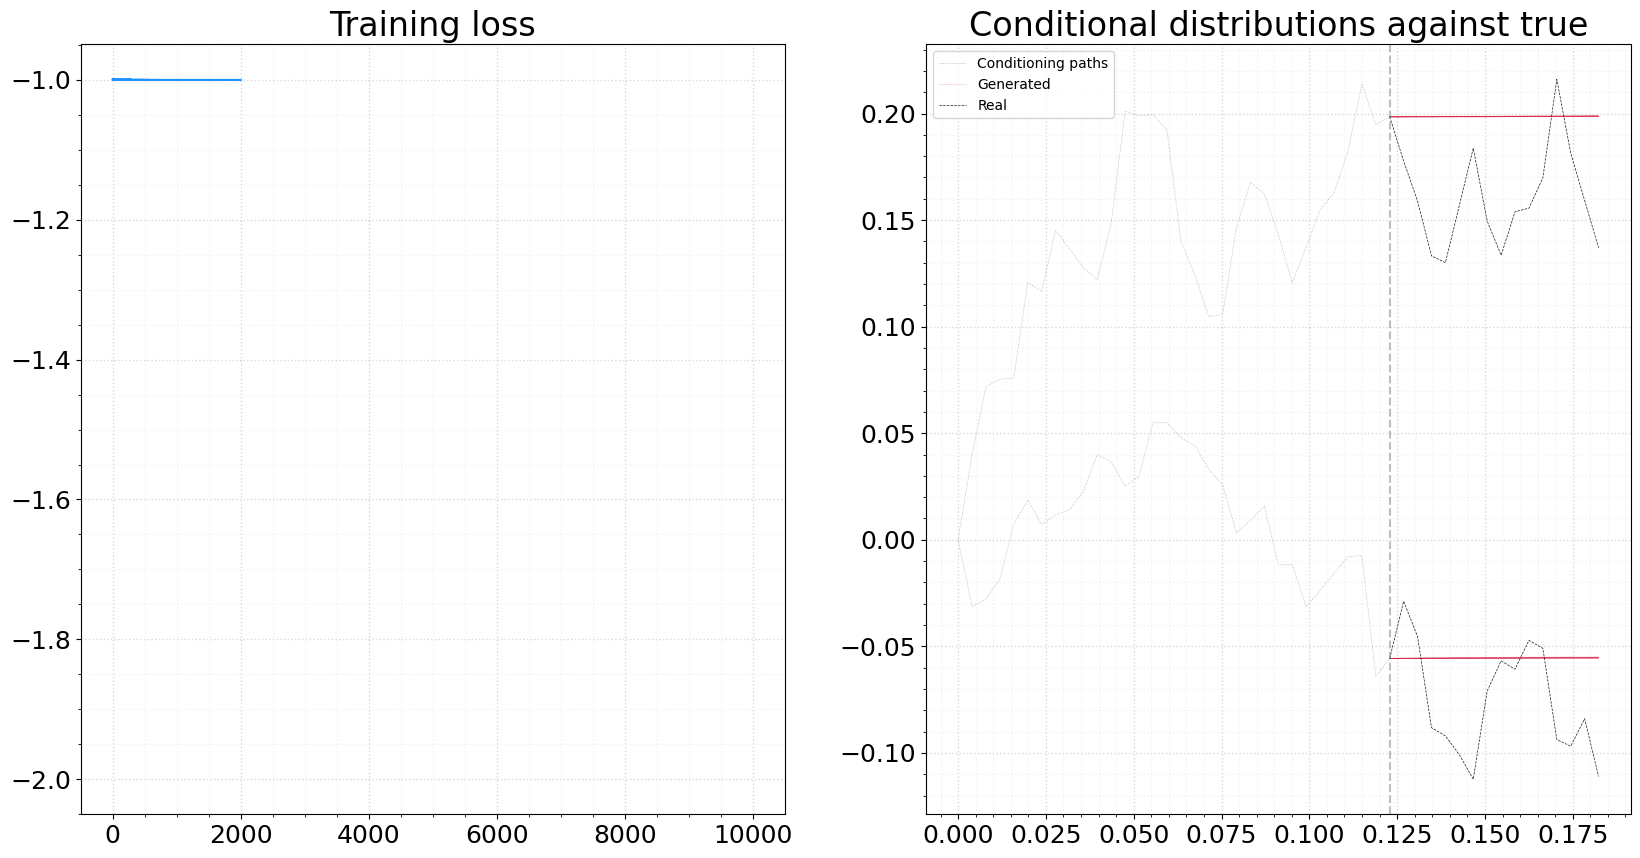

 20%|██        | 2001/10000 [36:58<3:01:23,  1.36s/it]

Step: 2000 Loss (unaveraged): -1.00002e+00 


 21%|██        | 2058/10000 [38:02<2:26:50,  1.11s/it]


KeyboardInterrupt: 

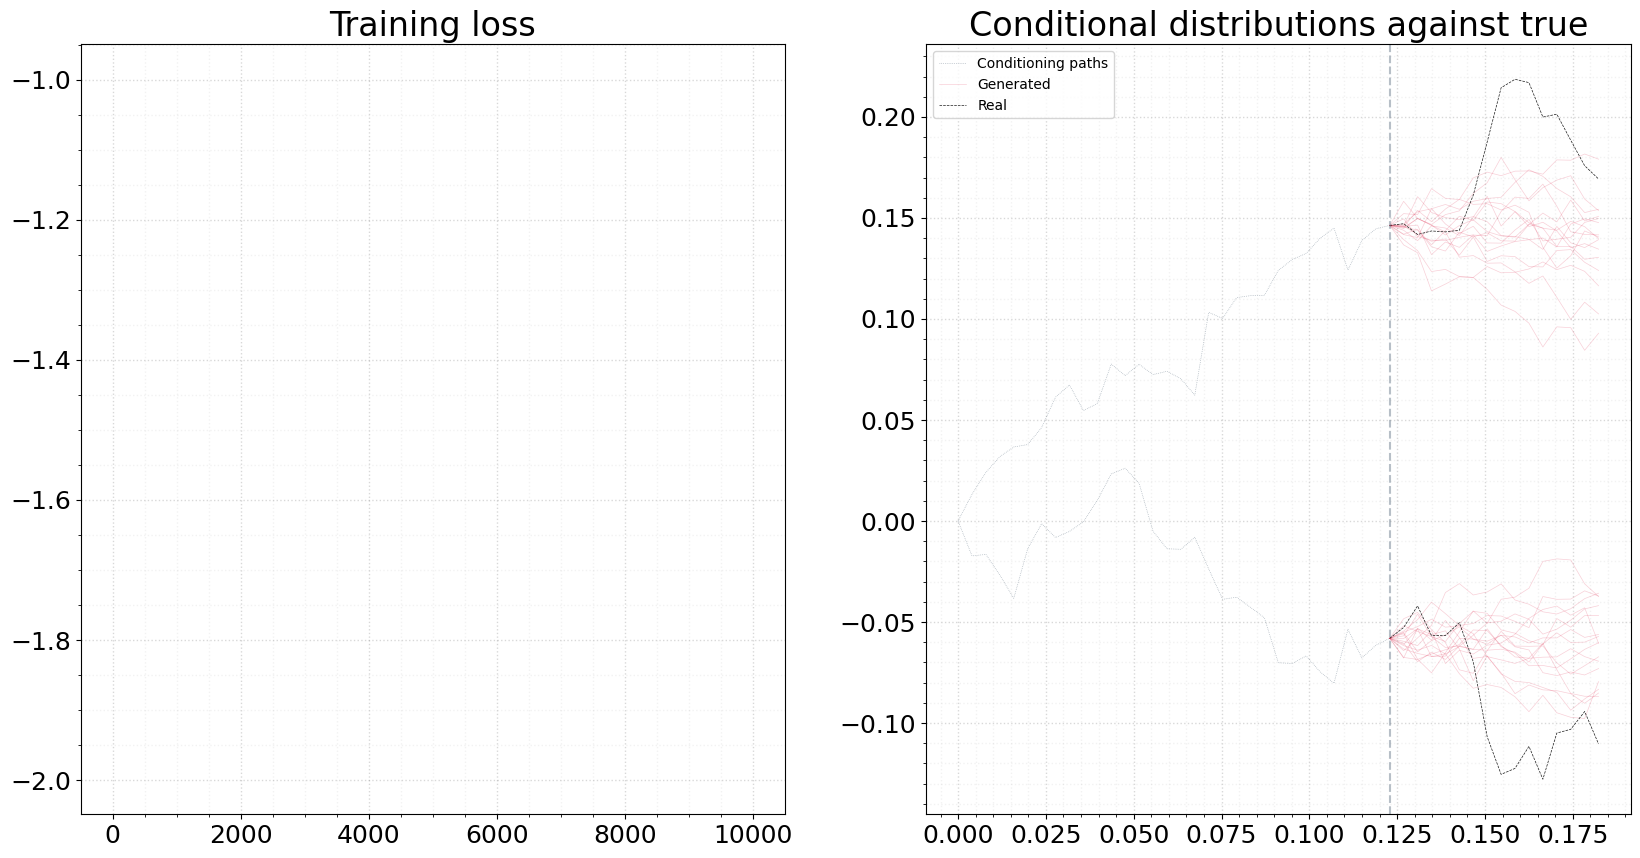

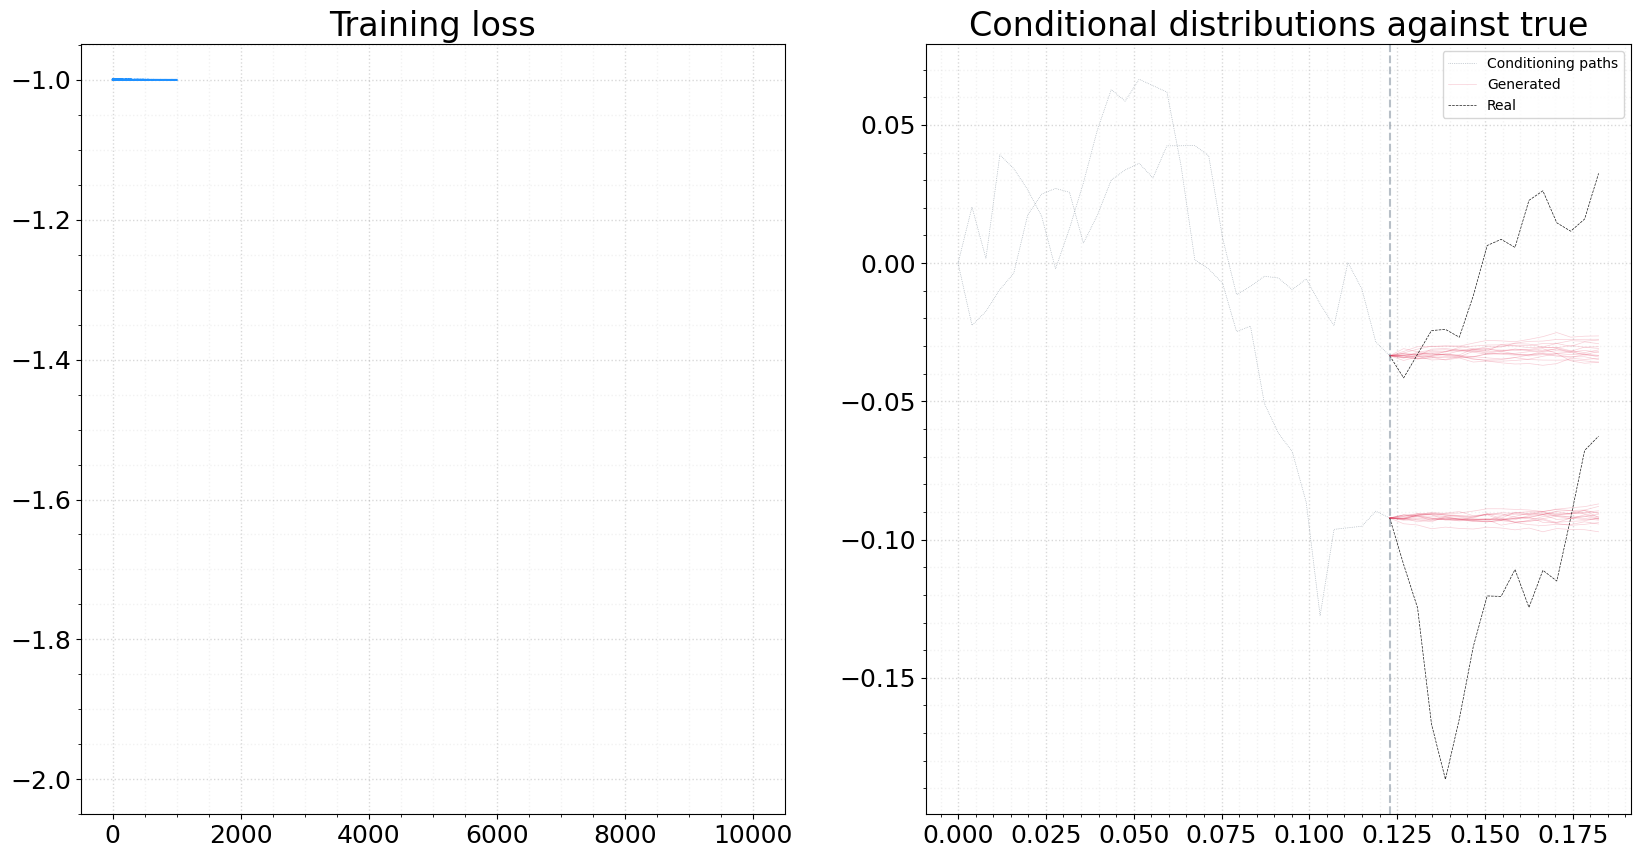

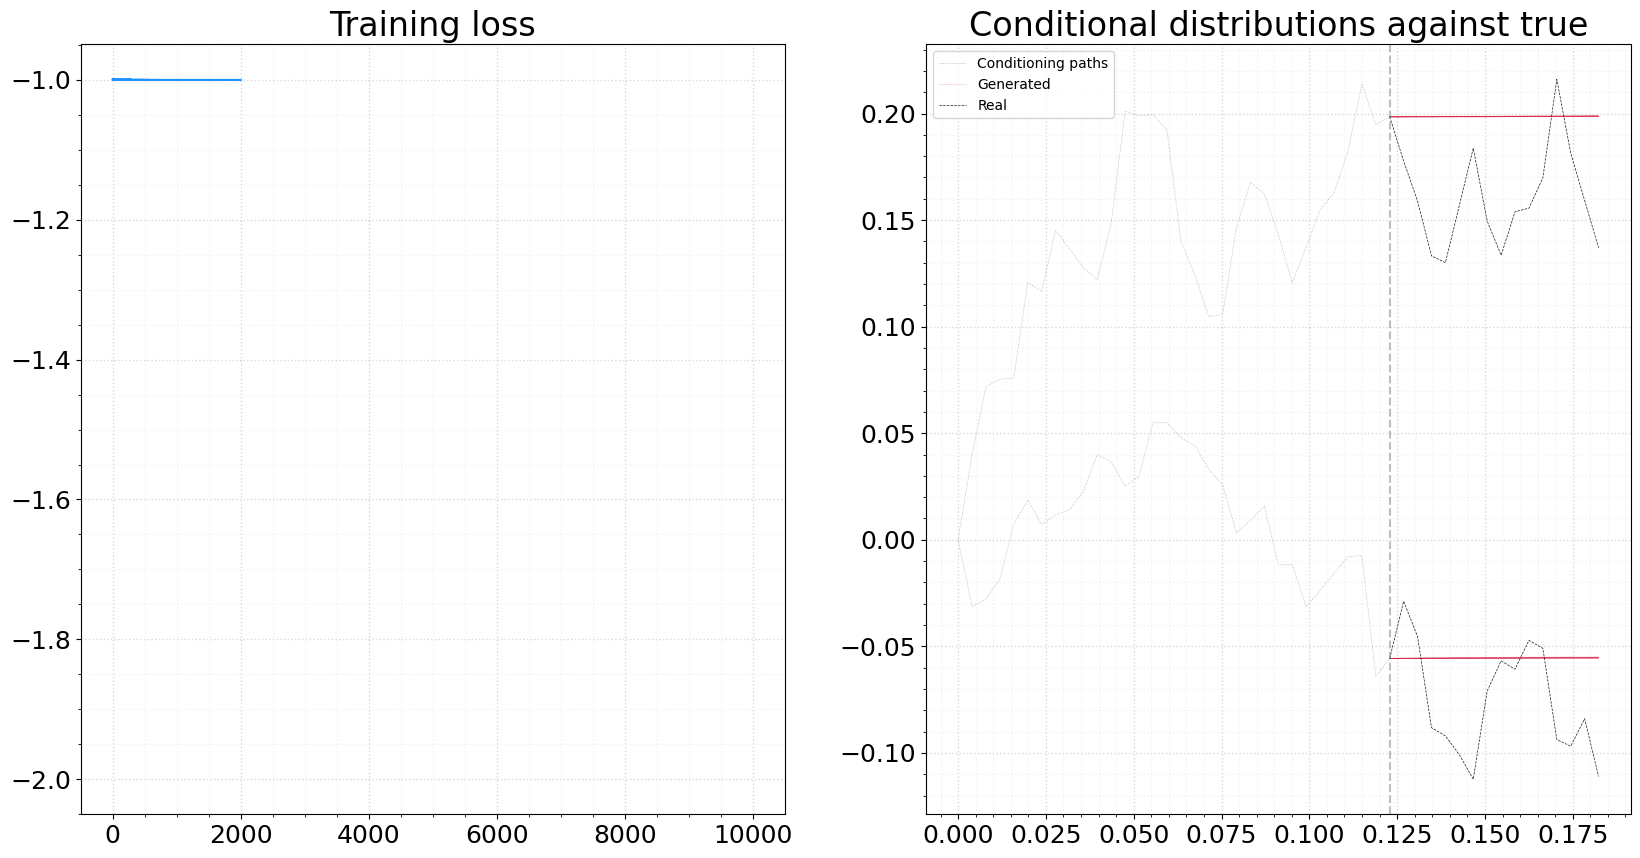

In [15]:
# Final training configurations
TRAIN_MODEL            = True   # Train the model or load a pre-existing one.

update_plots           = True   # See how training is going in real time.
num_plot_samples       = 2      # Number of conditional plot samples to display
emp_plot_size          = 16     # Size of empirical measure
calculate_dataset_loss = False  # Calculate loss over the entire dataset at the print stage. Can be quite slow!

gen_fp  = get_project_root().as_posix() + f"/saved_models/generators/{forex_pairs[0]}_{path_length}_{batch_size}_{output_dim}_{discriminator_args['sigma']}/"
disc_fp = get_project_root().as_posix() + f"/saved_models/discriminators/{forex_pairs[0]}_{path_length}_{batch_size}_{output_dim}_{discriminator_args['sigma']}/"

step_vec = np.arange(steps)
sigmas   = torch.zeros(steps)
loss_kwargs = {"emp_size": emp_size, "subtract_start": subtract_start}

if TRAIN_MODEL:
    tr_loss    = torch.zeros(steps, requires_grad=False).to(device)
    trange     = tqdm(range(steps), position=0, leave=True)
    criterions = []

    for step in trange:

        ###############################################################################
        ## Calculate loss
        ###############################################################################

        cond_samples, true_samples  = next(infinite_train_dataloader)

        loss = calculate_batch_conditional_scoring_loss(
            ts,
            discriminator,
            generator,
            batch_size,
            cond_samples,
            true_samples,
            cond_transformer,
            out_transformer,
            **loss_kwargs
        )

        loss.backward()

        tr_loss[step] += loss.clone().detach()

        ###############################################################################
        ## Plotting temporal results
        ###############################################################################
        if update_plots and ((step % steps_per_print == 0) or (step == steps - 1)):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            # Updating loss plot
            with torch.no_grad():
                np_tr_loss = tr_loss.cpu().numpy()

            ax1.plot(step_vec[:step], np_tr_loss[:step], alpha=1., color="dodgerblue", label="training_loss")
            ax1.plot(step_vec[step:], np_tr_loss[step:] + min(np_tr_loss), alpha=0.)
            ax1.grid(visible=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
            ax1.minorticks_on()
            ax1.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)
            ax1.set_title("Training loss")

            # Plotting path examples

            if subtract_start:
                true_samples = subtract_initial_point(true_samples)
                cond_samples = subtract_initial_point(cond_samples)

            true_times        = true_samples[..., 0].detach().cpu()
            cond_times        = cond_samples[..., 0].detach().cpu()
            true_plot_times   = true_times[:num_plot_samples].detach()
            cond_plot_times   = cond_times[:num_plot_samples].detach()


            true_plot_samples = true_samples[:num_plot_samples, :, 1:].detach().cpu()
            cond_plot_samples = cond_samples[:num_plot_samples, :, 1:].detach().cpu()

            # More plotting business
            if subtract_start:
                stpts_matrix = torch.tile(cond_plot_samples[:, -1, 0].unsqueeze(-1).unsqueeze(-1), (1, eval_length, 1))
            else:
                stpts_matrix = torch.zeros((batch_size, eval_length, data_size))

            tps                   = stpts_matrix.detach().cpu()
            true_plot_samples_adj = tps.clone() + true_plot_samples
            plot_ts               = ts.detach().cpu()
            plot_ts              -= torch.diff(plot_ts)[0]

            real_first      = True
            cond_first      = True
            generated_first = True

            for i, cond_sample_ in enumerate(cond_plot_samples):
                kwargs = {'label': 'Conditioning paths'} if cond_first else {}
                ax2.plot(tpast.cpu(), cond_sample_, color='slategrey', linewidth=0.5, alpha=0.7, linestyle="dotted", **kwargs)
                cond_first = False

                with torch.no_grad():
                    generated_samples = generator(ts, cond_transformer(cond_samples[i].unsqueeze(0)), emp_plot_size)[0]

                    if subtract_start:
                        generated_samples = subtract_initial_point(generated_samples)
                        generated_samples[..., 1] += torch.tile(cond_sample_[-1, 0], (emp_plot_size, eval_length, 1)).to(device)[..., 0]

                    generated_samples = generated_samples[..., 1].cpu()

                    for gen_sample_ in generated_samples:
                        kwargs = {'label': 'Generated'} if generated_first else {}
                        ax2.plot(plot_ts.cpu(), gen_sample_, color='crimson', linewidth=0.5, alpha=0.2, **kwargs)
                        generated_first = False

            for true_sample_ in true_plot_samples_adj:
                kwargs = {'label': 'Real'} if real_first else {}
                ax2.plot(plot_ts, true_sample_, color='black', linestyle="dashed", linewidth=0.5, alpha=0.9, **kwargs)
                real_first = False

            ax2.axvline(plot_ts[0], color="slategrey", linestyle="dashed", alpha=0.5)
            ax2.legend()
            ax2.grid(visible=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
            ax2.minorticks_on()
            ax2.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)
            ax2.set_title("Conditional distributions against true")

            display.clear_output(wait=True)
            display.display(plt.gcf())

        ###############################################################################
        ## Step through optimisers and adapting LR schedulers, stochastic weights
        ###############################################################################

        if adversarial:
            for param in discriminator.parameters():
                param.grad *= -1

            discriminator_optimiser.step()
            discriminator_optimiser.zero_grad()

            with torch.no_grad():

                if clip_disc_param:
                    for param in discriminator.parameters():
                        param.clamp_(1, 1e2)

                sigmas[step] = discriminator._sigma.item()

            if adapting_lr:
                d_scheduler.step()

        generator_optimiser.step()
        generator_optimiser.zero_grad()

        if adapting_lr:
            g_scheduler.step()

        # Stochastic weight averaging of generator (and discriminator, doesn't matter when not adversarial)
        if step > swa_step_start:
            averaged_generator.update_parameters(generator)
            averaged_discriminator.update_parameters(discriminator)

        ###############################################################################
        ## Batched loss calculation
        ###############################################################################
        if (step % steps_per_print) == 0 or step == steps - 1:
            # Print total loss on dataset
            if calculate_dataset_loss:
                total_unaveraged_loss = evaluate_conditional_scoring_loss(
                    ts, batch_size, discriminator, generator, train_dataloader, cond_transformer, out_transformer, **loss_kwargs
                )
            else:
                total_unaveraged_loss = loss.item()

            if step > swa_step_start:
                if calculate_dataset_loss:
                    total_averaged_loss = evaluate_conditional_scoring_loss(
                        ts, batch_size, averaged_discriminator, averaged_generator.module, train_dataloader, cond_transformer, out_transformer, **loss_kwargs
                    )

                else:
                    total_averaged_loss = loss.item()

                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.5e} "
                             f"Loss (averaged): {total_averaged_loss:.5e} ")
            else:
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.5e} ")

    ###############################################################################
    ## Training complete
    ###############################################################################
    mkdir(gen_fp)
    mkdir(disc_fp)
    torch.save(generator.state_dict(), gen_fp + f"path_cond_generator.pkl")
    torch.save(discriminator.state_dict(), disc_fp + f"path_cond_discriminator.pkl")

    torch.save(generator_config, gen_fp + "config.pkl")
    torch.save(discriminator_args, disc_fp + "config.pkl")

    torch.save(averaged_generator.state_dict(), gen_fp + "path_cond_generator_averaged.pkl")
    torch.save(averaged_discriminator.state_dict(), disc_fp + "path_cond_discriminator_averaged.pkl")

    plot_loss(tr_loss)
else:
    try:
        generator_state_dict     = torch.load(gen_fp + "path_cond_generator.pkl")
        discriminator_state_dict = torch.load(disc_fp + "path_cond_discriminator.pkl")

        averaged_generator_state_dict     = torch.load(gen_fp + "path_cond_generator_averaged.pkl")
        averaged_discriminator_state_dict = torch.load(disc_fp + "path_cond_discriminator_averaged.pkl")
    except FileNotFoundError:
        print("Model needs to be trained first. Please set TRAIN_MODEL to True.")

    generator.load_state_dict(generator_state_dict)
    discriminator.load_state_dict(discriminator_state_dict)

    averaged_generator.load_state_dict(averaged_generator_state_dict)
    averaged_discriminator.load_state_dict(averaged_discriminator_state_dict)

## 7. Evaluation 

We use this section to evaluate the training instance, along with the performance of the conditional GAN.

In [ ]:
if TRAIN_MODEL:

    fig, ax = plt.subplots(figsize=(10, 10))

    with torch.no_grad():
        np_tr_loss = tr_loss.cpu().numpy()

    ax.plot(step_vec[:step], np_tr_loss[:step], alpha=1., color="dodgerblue", label="training_loss")
    if adversarial:
        ax2 = ax.twinx()
        ax2.plot(sigmas[:step], color="grey", label="discriminator_sigmas", alpha=0.75)
    #ax.plot(step_vec[step:], np_tr_loss[step:], alpha=0.)
    ax.grid(visible=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
    ax.minorticks_on()
    ax.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)
    extra_title = " against discriminator sigma" if adversarial else ""
    ax.set_title("Training loss" + extra_title)
    ax.legend()

In [ ]:
## Synthetic example
n_evaluation_samples = 1
num_eval_paths       = 32

if data_type.lower() != "forex":

    # 1. Subsample from the conditioning paths and construct true distributions
    eval_indexes    = torch.randperm(batch_size)[:n_evaluation_samples]
    eval_cond_paths = cond_samples[eval_indexes].detach().cpu()/scale
    eval_true_paths = true_samples[eval_indexes].detach().cpu()/scale

    # 2. Un-normalise (as class tagging was done on the un-normalized paths)
    if normalisation is not None:
        val1, val2 = get_scalings(np_train_data[..., 1:], normalisation)
        val1 = torch.tensor(val1)
        val2 = torch.tensor(val2)

        norm_cond_paths = inv_normalize(eval_cond_paths, normalisation, val1=val1, val2=val2)
        norm_true_paths = inv_normalize(eval_true_paths, normalisation, val1=val1, val2=val2)
    else:
        norm_cond_paths = eval_cond_paths
        norm_true_paths = eval_true_paths

    # 3. Loop over conditional samples and plot distributions against true
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    make_grid(axis=ax)

    ts_cond = tpast.cpu()
    ts_true = ts.cpu() - 1

    gen_first  = True
    cf_first   = True
    cond_first = True
    true_first = True

    for cp, tp in zip(norm_cond_paths, norm_true_paths):
        # Check what class this path belongs to

        cp += S0

        nm_val = mfunc(np.diff(cp[:, 1])).sum()
        if nm_val < quantiles[0]:
            class_ = 0
        elif (nm_val >= quantiles[0]) and (nm_val < quantiles[1]):
            class_ = 1
        else:
            class_ = 2

        # Generate bank of counterfactuals
        this_mu, this_sig = eval(f"mu{int(class_)}"), eval(f"sig{int(class_)}")
        this_S0           = torch.tile(cp[-1, 1], (num_eval_paths, 1)).flatten().cpu().numpy()

        this_mu  = np.array(this_mu)
        this_sig = np.array(this_sig)
        cfs      = process_generator(
            num_eval_paths, dt*eval_length, eval_length, this_mu, this_sig, this_S0, proc=process_type
        )

        # Generate a counterfactual
        cp_t     = torch.clone(cp)

        if normalisation is not None:
            cp_t = normalize(cp_t, normalisation, val1=val1, val2=val2)

        cp_t[..., 1] = cp[..., 1] * scale
        cp_t         = cond_transformer(cp.unsqueeze(0))

        if subtract_initial_point:
            cp_t = subtract_initial_point(cp_t)

        gen_cfs = generator(ts, cp_t, num_eval_paths)[0].cpu()/scale

        if normalisation is not None:
            gen_cfs = inv_normalize(gen_cfs, normalisation, val1=val1, val2=val2)

        if subtract_initial_point:
            gen_cfs      = subtract_initial_point(gen_cfs)
            tp           = tp[:, 1] - tp[0, 1]
            plot_gen_cfs = gen_cfs[..., 1].detach().cpu().numpy() + cp[-1, 1].item()
            tp           = tp + cp[-1, 1].item()

        plot_cond = cp[..., 1].cpu()

        # Plot the results
        label = "conditioning_path" if cond_first else ""
        ax.plot(ts_cond, plot_cond, color="slategrey", alpha=0.3, label=label)
        cond_first = False
        for cfp in cfs:
            label = "true_counterfactual" if cf_first else ""
            ax.plot(ts_true, cfp, color="dodgerblue", alpha=0.1, label=label)
            cf_first = False
        for pgcf in plot_gen_cfs:
            label = "generated_counterfactual" if gen_first else ""
            ax.plot(ts_true, pgcf, color="tomato", alpha=0.1, label=label)
            gen_first = False
        ax.plot(ts_true, tp, color="black", linestyle="dashed", alpha=0.5, label="true_path" if true_first else "")
        true_first = False
        ax.set_title("Distribution of conditional generator vs true counterfactuals")
    ax.legend()
else:
    # 1. Generate examples
    path_types = ["lowest", "random", "extreme"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))


    for ax, path_type in zip(axes, path_types):
        with torch.no_grad():
            x, y    = next(iter(test_dataloader))
            t_x     = cond_transformer(subtract_initial_point(x.clone()))
            gen_y   = generator(ts, t_x, num_eval_paths).cpu()
            t_gen_y = batch_subtract_initial_point(gen_y)
            t_y     = subtract_initial_point(y.clone())

            # 2. Pick the highest and lowest qv input paths
            _x    = subtract_initial_point(x)
            qvs   = torch.sum(torch.pow(torch.diff(_x[..., 1], axis=1), 2), axis=1)
            s_qvs = torch.argsort(qvs)

            if path_type == "extreme":
                inds_ = [s_qvs[-i] for i in range(1, n_evaluation_samples + 1)]
            elif path_type == "lowest":
                inds_ = [s_qvs[i] for i in range(n_evaluation_samples)]
            else:
                inds_ = [s_qvs[torch.randint(0, len(s_qvs), (n_evaluation_samples,)).item()]]

            # 3. Create plot objects
            _p_x     = subtract_initial_point(x)
            ts_cond  = _p_x[0, :, 0].cpu()/scale
            ts_eval  = t_y[0, :, 0].cpu()/scale - 1
            plot_x   = _p_x[inds_, :, 1:].cpu()
            plot_y   = t_y[inds_, :, 1:].cpu()
            plot_g_y = t_gen_y[inds_, :, :, 1:].cpu()

        # 4. Add initial point
        n_ts_cond = len(ts_cond)
        n_ts_eval = len(ts_eval)
        tv_x      = plot_x[:, -1, :]
        ip_add    = torch.tile(tv_x, (1, eval_length)).unsqueeze(-1)
        plot_y   += ip_add
        plot_g_y += torch.tile(ip_add.unsqueeze(1), (1, num_eval_paths, 1, 1))
        # 5. Loop over conditions and plot
        #make_grid(axis=ax)

        #ax.set_ylim([-20, 20])

        gen_first  = True
        cond_first = True
        true_first = True

        for px, py, gpy in zip(plot_x, plot_y, plot_g_y):
            # label = r"$x$" if cond_first else ""
            label = 'x'
            ax.plot(ts_cond, px, color="black", alpha=0.25, label=label)
            cond_first = False
            for pgcf in gpy:
                # label = r"$\mathbb{P}_{X^\theta}(\cdot|x)$" if gen_first else ""
                label = 'P_X'
                ax.plot(ts_eval, pgcf, color="dodgerblue", alpha=0.1, label=label)
                gen_first = False
            label = 'y~P(|X)'
            ax.plot(ts_eval, py, color="black", linestyle="dashed", alpha=0.5, label=label if true_first else "")
            ax.plot(ts_eval, gpy[..., 0].min(axis=0).values, color="dodgerblue", alpha=0.5)
            ax.plot(ts_eval, gpy[..., 0].max(axis=0).values, color="dodgerblue", alpha=0.5)

            true_first = False
        ax.legend(fontsize=18)
        ax.axvline(ts_eval[0], color="grey", linestyle="dashed", alpha=0.25)
        ax.set_xlabel('t', fontsize=16)
        ax.set_ylabel('X_t', fontsize=16)
        # ax.set_xlabel(r"$t$", fontsize=16)
        # ax.set_ylabel(r"$X_t$", fontsize=16)
        #ax.set_title(r"Distribution of generated conditional distribution against realised path, EUR/USD", fontsize=11)

    plt.tight_layout()
    plt.savefig('cond_results.png', dpi=100)
    plt.show()
